In [10]:
import Pkg
Pkg.activate("../../Tasks2D")

using Revise, Plots
import LineWorlds
const L = LineWorlds
const Geo = L.Geometry

import GridWorlds
const GW = GridWorlds

using Gen
import GenPOMDPs

using VoxelRayTracers # For lineworld -> gridworld
using AStarSearch     # For gridworld path planning

  Activating project at `~/Developer/research/summer2023/tasks2d/Tasks2D`


In [33]:
(_segs, _bb, _center) = L.load_env_sparse("/Users/georgematheos/Developer/research/summer2023/tasks2d/data/environments/ambig.json")
# L.load_env_sparse("../../data/environments", 2)

(_segs = LineWorlds.Geometry.Segment[LineWorlds.Geometry.Segment([0.0, 0.0], [5.4, 0.0]), LineWorlds.Geometry.Segment([5.4, 0.0], [5.4, 12.0]), LineWorlds.Geometry.Segment([5.4, 12.0], [0.0, 12.0]), LineWorlds.Geometry.Segment([0.0, 12.0], [0.0, 0.0]), LineWorlds.Geometry.Segment([0.0, 0.0], [0.0, 2.0]), LineWorlds.Geometry.Segment([0.0, 2.0], [4.0, 2.0]), LineWorlds.Geometry.Segment([4.0, 2.0], [4.0, 3.0]), LineWorlds.Geometry.Segment([4.0, 3.0], [4.0, 2.0]), LineWorlds.Geometry.Segment([4.0, 2.0], [0.0, 2.0]), LineWorlds.Geometry.Segment([0.0, 2.0], [0.0, 6.0])  …  LineWorlds.Geometry.Segment([4.0, 6.0], [4.0, 7.0]), LineWorlds.Geometry.Segment([4.0, 7.0], [4.0, 6.0]), LineWorlds.Geometry.Segment([4.0, 6.0], [0.0, 6.0]), LineWorlds.Geometry.Segment([0.0, 6.0], [0.0, 10.0]), LineWorlds.Geometry.Segment([0.0, 10.0], [4.0, 10.0]), LineWorlds.Geometry.Segment([4.0, 10.0], [4.0, 8.0]), LineWorlds.Geometry.Segment([4.0, 8.0], [4.0, 10.0]), LineWorlds.Geometry.Segment([4.0, 10.0], [0.0, 10.

In [34]:
function line_to_grid(_segs, _bb, ϵ)
    (x1, y1), (x2, y2) = _bb
    edges = ((x1 - ϵ):ϵ:(x2 + ϵ), (y1 - ϵ):ϵ:(y2 + ϵ))

    grid = [false for _ in edges[1], _ in edges[2]]
    for seg in _segs
        if Geo.diff(seg) ≈ [0, 0]
            continue
        end
        ray = (position=seg.x, velocity=Geo.diff(seg))
        for hit in eachtraversal(ray, edges)
                                    # TODO: is this a hack or no?
            if hit.exit_time ≤ 1. #|| (hit.entry_time == 1.0 && (ray.velocity[1] > 0 || ray.velocity[2] > 0))
                grid[hit.voxelindex] = true
            end
        end
    end

    linecoords_to_gridcoords(x, y) = (
        Int(round((x - edges[1][1] + ϵ) / ϵ)),
        Int(round((y - edges[2][1] + ϵ) / ϵ))
    )
    gridcoords_to_linecoords(x, y) = (
        edges[1][x],
        edges[2][y]
    )

    return grid, edges, linecoords_to_gridcoords, gridcoords_to_linecoords
end

line_to_grid (generic function with 1 method)

In [35]:
ϵ = 0.25
(grid, edges, l_to_g, g_to_l) = line_to_grid(_segs, _bb, ϵ)
w = GridWorlds.boolmatrix_to_grid(grid, (length(edges[1]), length(edges[2])))

GridWorlds.FGridWorld(FunctionalCollections.PersistentVector{GridWorlds.GridCell}[[GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty  …  GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty], [GridWorlds.empty, GridWorlds.wall, GridWorlds.wall, GridWorlds.wall, GridWorlds.wall, GridWorlds.wall, GridWorlds.wall, GridWorlds.wall, GridWorlds.wall, GridWorlds.wall  …  GridWorlds.wall, GridWorlds.wall, GridWorlds.wall, GridWorlds.wall, GridWorlds.wall, GridWorlds.wall, GridWorlds.wall, GridWorlds.wall, GridWorlds.wall, GridWorlds.empty], [GridWorlds.empty, GridWorlds.wall, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.wall  …  GridWorlds.wall, GridWor

In [51]:
taxi_dist((x, y), (x2, y2)) = abs(x - x2) + abs(y - y2)
function find_action_using_grid(start_linecoords, goal_linecoords)
    actions = (:up, :down, :left, :right, :stay)
    initialpos = l_to_g(start_linecoords...)
    goalpos    = l_to_g(goal_linecoords...)

    results = astar(
        # state to neighbors
        pos -> unique(GW.newpos(w, pos, dir) for dir in actions),
        initialpos, # Initial world state
        goalpos; # Goal world state
        heuristic = ((pos, goal) -> taxi_dist(pos, goal)),
        isgoal = ((pos, goal) -> pos == goal),
        timeout = 10.
    )

    next_state = results.path[2]
    # println("next_state: ", g_to_l(next_state...))
    action = actions[findfirst(GW.newpos(w, initialpos, dir) == next_state for dir in actions)]

    return (action, results.path)
end

find_action_using_grid (generic function with 1 method)

In [52]:
(a, path) = find_action_using_grid((3., 4.), (1., 12.))

(:right, [(14, 18), (15, 18), (16, 18), (17, 18), (17, 17), (18, 17), (19, 17), (19, 18), (19, 19), (19, 20)  …  (15, 49), (14, 49), (13, 49), (12, 49), (11, 49), (10, 49), (9, 49), (8, 49), (7, 49), (6, 49)])

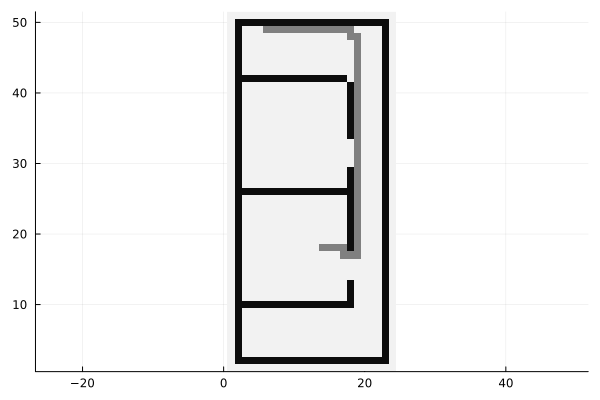

In [42]:
results_grid = [false for _ in edges[1], _ in edges[2]]
for pos in path
    results_grid[pos...] = true
end

heatmap(transpose([
    w ? 0 : r ? 0.5 : 1
    for (w, r) in zip(grid, results_grid)
]), aspect_ratio=:equal, color=:grays, cbar=false)


In [94]:
PARAMS = (;
    map = _segs,
    orientation = π/2,
    bounding_box = L.bounding_box(_segs),
    step = (;
        Δ = 0.25,
        σ = 0.1
    ),
);

In [95]:
mvuniform = L.ProductDistribution(uniform);
@gen (static) function uniform_agent_pos(params)
    w = params.map # a map, represented as list of line segments
    
    mins, maxs = PARAMS.bounding_box
    pos ~ mvuniform(mins, maxs)
    
    return pos
end
@load_generated_functions()

### Motion model ###
# The next position, under a 0-noise model, with no walls.
function det_next_pos((x, y), a, Δ)
    a == :up    ? [x, y + Δ] :
    a == :down  ? [x, y - Δ] : 
    a == :left  ? [x - Δ, y] :
    a == :right ? [x + Δ, y] :
    a == :stay  ? [x, y]     :
                error("Unrecognized action: $a")
end
function handle_wall_intersection(prev, new, walls)
    move = L.Segment(prev, new)
    for wall in walls
        do_intersect, dist = L.Geometry.cast(move, wall)
        if do_intersect && dist ≤ L.Geometry.norm(move)
            return prev
        end
    end
    return new
end
@gen (static) function motion_model(prev_pos, action, PARAMS)
    np = det_next_pos(prev_pos, action, PARAMS.step.Δ)
    pos ~ broadcasted_normal(np, PARAMS.step.σ)
    
    next_pos = handle_wall_intersection(prev_pos, pos, PARAMS.map)
    
    return next_pos
end

### Fully observable ###
@gen function obs_model(pos, params)
    return pos
end

# POMDP of this environment
pomdp = GenPOMDPs.GenPOMDP(
    uniform_agent_pos,       # INIT   : params                      ⇝ state
    motion_model,            # STEP   : prev_state, actions, params ⇝ state
    obs_model,               # OBS    : state, params               ⇝ observation
    (state, action) -> 0.    # UTILITY: state, action, params       → utility
)

# Generative function over trajectories of the POMDP,
# given a fixed action sequence.
trajectory_model = GenPOMDPs.ControlledTrajectoryModel(pomdp)

@load_generated_functions()

In [96]:
state_addr = GenPOMDPs.state_addr
tr, take_action = GenPOMDPs.interactive_world_trace(trajectory_model, PARAMS, choicemap((state_addr(0, :pos), [3., 4.])));

In [103]:
GOAL = [1., 12.];

In [98]:
T(tr) = get_args(tr)[1]
currentpos(tr) = tr[state_addr(T(tr), :pos)]

currentpos (generic function with 1 method)

In [99]:
while Geo.norm(currentpos(tr[]) - GOAL) > 2.0 && T(tr[]) < 100
    action = find_action_using_grid(currentpos(tr[]), GOAL)[1]
    take_action(action)
end

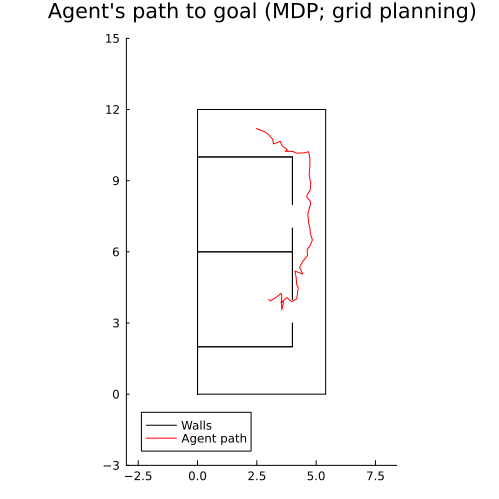

In [109]:
mypl = plot(size=(500,500), aspect_ratio=:equal, title="Agent's path to goal (MDP; grid planning)", grid=false,
    xlim=(_bb[1][1]-3, _bb[2][1]+3),
    ylim=(_bb[1][2]-3, _bb[2][2]+3),
    legend=:bottomleft,
)
plot!(_segs, c=:black, label="Walls")
plot!(GenPOMDPs.state_sequence(tr[]), c=:red, label="Agent path")